In [1]:
"""
Created on 2019/02/24

WGAN-SN using Keras

Source: 
1. https://github.com/bojone/gan/blob/master/keras/wgan_sn_celeba.py
2. http://www.twistedwg.com/2018/10/13/SNGAN.html
"""

"""
觀念補充:

卷積output圖片size計算: N=(W−F+2P)/S+1
    輸入圖片矩陣為：WxW 
    卷積核大小，kernel_size：FxF 
    步長strides：S 
    邊界擴充padding的值：P

逆卷積output圖片size計算: W=(N−1)∗S−2P+F
    輸入圖片矩陣為：NxN 
    卷積核大小，kernel_size：FxF 
    步長strides：S 
    邊界擴充padding的值：P

"""

'\n觀念補充:\n\n卷積output圖片size計算: N=(W−F+2P)/S+1\n    輸入圖片矩陣為：WxW \n    卷積核大小，kernel_size：FxF \n    步長strides：S \n    邊界擴充padding的值：P\n\n逆卷積output圖片size計算: W=(N−1)∗S−2P+F\n    輸入圖片矩陣為：NxN \n    卷積核大小，kernel_size：FxF \n    步長strides：S \n    邊界擴充padding的值：P\n\n'

# Import

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data preparation

## CelebA

In [12]:
if not os.path.exists('celebA_samples'):
    os.mkdir('celebA_samples')

imgs_path = Path("/home/rossleecooloh/workspace/Dateset/CelebA/img_align_celeba/")

def read_img(imgs_path, img_dim=64):
    # imgs = []
    # for i, img in enumerate(imgs_path.rglob("*.jpg")):
    input_image = cv2.imread(str(imgs_path))
    input_image = cv2.resize(input_image, (img_dim, img_dim))
    input_image = input_image[:, :, ::-1] # BGR -> RGB
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    # imgs.append(input_image)
    
    return input_image

imgs = list(imgs_path.rglob("*.jpg"))

# x_train = read_imgs(imgs_path)  # 20幾萬張，太大，先取50000張
# np.random.shuffle(x_train)
# x_train = x_train[:50000]

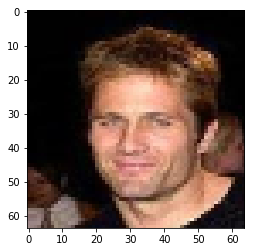

In [14]:
plt.imshow(read_img(imgs[3000]))

## Complex

In [3]:
if not os.path.exists('samples'):
    os.mkdir('samples')

imgs_path = Path("/home/rossleecooloh/workspace/Dateset/thumbnails_features_deduped_publish")

def read_img(imgs_path, img_dim=64):
    # imgs = []
    # for i, img in enumerate(imgs_path.rglob("*.jpg")):
    input_image = cv2.imread(str(imgs_path))
    input_image = cv2.resize(input_image, (img_dim, img_dim))
    input_image = input_image[:, :, ::-1] # BGR -> RGB
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    # imgs.append(input_image)
    
    return input_image

imgs = list(imgs_path.rglob("*.jpg"))

# x_train = read_imgs(imgs_path)  # 20幾萬張，太大，先取50000張
# np.random.shuffle(x_train)
# x_train = x_train[:50000]

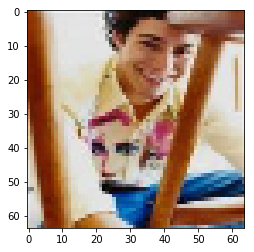

In [10]:
plt.imshow(read_img(imgs[1000]))

## Image training generator

In [15]:
def data_generator(batch_size=32):
    X = []
    while True:
        # print(123)
        np.random.shuffle(imgs)
        # 只要有yield就是generator，把生成器想成是中斷點還沒跑完的東西
        # 照理說叫了這個func，因為有while True，所以會一直無限迴圈while裡面東西
        # 但這裡因為圖片數量實在太多，所以一直卡在for path...這個loop裡
        for path in imgs:
            X.append(read_img(path))
            if len(X) == batch_size:
                # print(456)
                X = np.array(X)
                yield X
                X = []  # 所以這裡還要清空一波

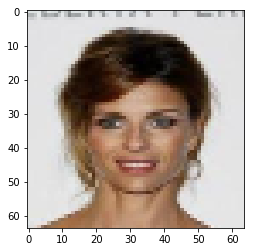

In [18]:
# x = data_generator()
plt.imshow(next(x)[0]) # (batch, 64, 64, 3)

# Model

## Hyperparameters

In [19]:
height, width = read_img(imgs[0]).shape[:2]
# center_height = int((height - width) / 2)
img_dim = 64
z_dim = 100

## Spectral norm

In [20]:
def spectral_norm(w, r=5):
    w_shape = K.int_shape(w)
    in_dim = np.prod(w_shape[:-1]).astype(int)
    out_dim = w_shape[-1]
    w = K.reshape(w, (in_dim, out_dim))
    u = K.ones((1, in_dim))
    for i in range(r):
        v = K.l2_normalize(K.dot(u, w))
        u = K.l2_normalize(K.dot(v, K.transpose(w)))
    return K.sum(K.dot(K.dot(u, w), K.transpose(v)))


def spectral_normalization(w):
    return w / spectral_norm(w)

## Discriminator
`Discriminator的每層都要加normalization的限制`

In [21]:
x_in = Input(shape=(img_dim, img_dim, 3))
x = x_in

x = Conv2D(img_dim,
           (5, 5),
           strides=(2, 2),
           padding='same',
           kernel_constraint=spectral_normalization)(x)
x = LeakyReLU()(x)

for i in range(3):
    x = Conv2D(img_dim * 2**(i + 1),
               (5, 5),
               strides=(2, 2),
               padding='same',
               kernel_constraint=spectral_normalization)(x)
    x = BatchNormalization(gamma_constraint=spectral_normalization)(x)
    x = LeakyReLU()(x)

x = Flatten()(x)
x = Dense(1, use_bias=False,
          kernel_constraint=spectral_normalization)(x) 

d_model = Model(x_in, x)
d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         819456    
__________

## Generator

In [22]:
height, width = read_img(imgs[0]).shape[:2]
img_dim = 64
z_dim = 100

z_in = Input(shape=(z_dim, ))
z = z_in

z = Dense(4 * 4 * img_dim * 8)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Reshape((4, 4, img_dim * 8))(z)

for i in range(3):
    z = Conv2DTranspose(filters=img_dim * 4 // 2 ** i,
                       kernel_size=(5, 5),
                       strides=(2, 2),
                       padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

z = Conv2DTranspose(filters=3,
                   kernel_size=(5, 5),
                   strides=(2, 2),
                   padding='same')(z)
z = Activation('tanh')(z)

g_model = Model(z_in, z)
g_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_6 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 256)         1024      
__________

# Integrated Training

## Trained on CelebA

In [25]:
g_model.load_weights("g_weights_dcgan_sn_align_celebA.h5")
d_model.load_weights("d_weights_dcgan_sn_align_celebA.h5")

# 訓練D
x_in = Input(shape=(img_dim, img_dim, 3))
z_in = Input(shape=(z_dim, ))

d_model.trainable = True
g_model.trainable = False

x_fake = g_model(z_in)
x_real_score = d_model(x_in)
x_fake_score = d_model(x_fake)

d_train_model = Model([x_in, z_in],
                      [x_real_score, x_fake_score])
# 用假圖分數 - 真圖分數(越小越好)
d_loss = K.mean(x_fake_score - x_real_score)
d_train_model.add_loss(d_loss)
d_train_model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5))

print("-" * 10 + "Train Discriminator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Discriminator")
d_train_model.summary()


# 訓練G
g_model.trainable = True
d_model.trainable = False

x_fake_score = d_model(g_model(z_in))  # 串起來
g_train_model = Model(z_in, x_fake_score)
g_train_model.add_loss(K.mean(-x_fake_score))
g_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))

print("-" * 10 + "Train Generator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Generator")
g_train_model.summary()

def sample_images(path):
    n = 9
    figure = np.zeros((img_dim * n, img_dim * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1, z_dim)
            x_sample = g_model.predict(z_sample)
            digit = x_sample[0]
            figure[i * img_dim:(i + 1) * img_dim,
                   j * img_dim:(j + 1) * img_dim] = digit
    # figure = (figure + 1) / 2 * 255
    figure = figure * 255
    figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
    figure = np.round(figure, 0).astype(int)
    cv2.imwrite(path, figure)

iters_per_drawing = 100
total_iter = 10000
batch_size = 128
img_generator = data_generator(batch_size)

for i in range(total_iter):
    for d in range(3):
        z_noise = np.random.randn(batch_size, z_dim)
        # 丟入batch_size的真圖和noise
        d_loss = d_train_model.train_on_batch(x=[next(img_generator), z_noise], y=None)
    for g in range(1):
        z_noise = np.random.randn(batch_size, z_dim)
        g_loss = g_train_model.train_on_batch(x=z_noise, y=None)
    if i % 10 == 0:
        print('iter: %s, d_loss: %s, g_loss: %s' % (i, d_loss, g_loss))
    if i % iters_per_drawing == 0:
        sample_images('celebA_samples/test_%s.png' % i)
        # g_train_model.save_weights('./g_train_model.weights')

g_model.save_weights("g_weights_dcgan_sn_align_celebA.h5")
d_model.save_weights("g_weights_dcgan_sn_align_celebA.h5")

----------Train Discriminator----------
Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_6 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Ba

iter: 0, d_loss: -2.509336, g_loss: 1.2934768
iter: 10, d_loss: -3.9561863, g_loss: 2.0328357
iter: 20, d_loss: -2.7802386, g_loss: 1.8126066
iter: 30, d_loss: -3.535527, g_loss: 1.9525367
iter: 40, d_loss: -3.6869893, g_loss: 1.955551
iter: 50, d_loss: -3.2120056, g_loss: 1.600696
iter: 60, d_loss: -3.636995, g_loss: 2.1986365
iter: 70, d_loss: -3.7378204, g_loss: 2.0876484
iter: 80, d_loss: -3.95529, g_loss: 2.0100002
iter: 90, d_loss: -3.9899018, g_loss: 1.9868239
iter: 100, d_loss: -4.0022373, g_loss: 2.0175872
iter: 110, d_loss: -3.953355, g_loss: 2.1931386
iter: 120, d_loss: -3.0341628, g_loss: 2.223065
iter: 130, d_loss: -3.4179432, g_loss: 1.7353821
iter: 140, d_loss: -2.935736, g_loss: 1.8547881
iter: 150, d_loss: -4.0064287, g_loss: 2.1873798
iter: 160, d_loss: -3.9720252, g_loss: 1.772121
iter: 170, d_loss: -4.157233, g_loss: 2.457137
iter: 180, d_loss: -3.5583925, g_loss: 2.0672984
iter: 190, d_loss: -4.366496, g_loss: 2.254506
iter: 200, d_loss: -4.1856284, g_loss: 2.19057

iter: 1690, d_loss: -1.3174205, g_loss: 2.5916586
iter: 1700, d_loss: -3.8763885, g_loss: 1.5345747
iter: 1710, d_loss: -4.118811, g_loss: 1.4862587
iter: 1720, d_loss: -3.8691492, g_loss: 1.4777539
iter: 1730, d_loss: -3.203743, g_loss: 1.2130545
iter: 1740, d_loss: -4.165571, g_loss: 1.711605
iter: 1750, d_loss: -3.4630404, g_loss: 3.172217
iter: 1760, d_loss: -3.7516704, g_loss: 2.8924556
iter: 1770, d_loss: -3.5396352, g_loss: 2.404129
iter: 1780, d_loss: -3.7996697, g_loss: 2.3483257
iter: 1790, d_loss: -3.980822, g_loss: 2.9997
iter: 1800, d_loss: -2.9055316, g_loss: 2.780064
iter: 1810, d_loss: -2.9818287, g_loss: 0.50417626
iter: 1820, d_loss: -3.9699404, g_loss: 2.348204
iter: 1830, d_loss: -3.9451065, g_loss: 2.6803122
iter: 1840, d_loss: -3.841086, g_loss: 2.153109
iter: 1850, d_loss: -4.444264, g_loss: 2.7403615
iter: 1860, d_loss: -4.6155214, g_loss: 2.9171138
iter: 1870, d_loss: -3.9366753, g_loss: 1.4798452
iter: 1880, d_loss: -3.7651353, g_loss: 2.8964276
iter: 1890, d_

iter: 3350, d_loss: -3.6446676, g_loss: 3.2565057
iter: 3360, d_loss: -3.2280242, g_loss: 0.75595444
iter: 3370, d_loss: -2.4836144, g_loss: 2.2915444
iter: 3380, d_loss: -4.2007575, g_loss: 2.647961
iter: 3390, d_loss: -6.3782873, g_loss: 3.3171506
iter: 3400, d_loss: -2.8561664, g_loss: -1.4863617
iter: 3410, d_loss: -3.1124763, g_loss: 2.8380027
iter: 3420, d_loss: -3.0192902, g_loss: 2.2007732
iter: 3430, d_loss: -3.6043894, g_loss: 2.7804651
iter: 3440, d_loss: -5.1310782, g_loss: 2.958402
iter: 3450, d_loss: -3.846153, g_loss: 2.7839253
iter: 3460, d_loss: -3.7100778, g_loss: 2.9166725
iter: 3470, d_loss: -4.016, g_loss: 3.3429985
iter: 3480, d_loss: -3.102017, g_loss: 2.6260414
iter: 3490, d_loss: -4.4910016, g_loss: 2.7506056
iter: 3500, d_loss: -3.858481, g_loss: 3.3191586
iter: 3510, d_loss: -4.1430535, g_loss: 2.6841035
iter: 3520, d_loss: -4.19869, g_loss: 2.946312
iter: 3530, d_loss: -3.5684466, g_loss: 3.1639686
iter: 3540, d_loss: -3.0648618, g_loss: 1.0749943
iter: 3550

iter: 5010, d_loss: -3.2788944, g_loss: 1.1781445
iter: 5020, d_loss: -2.6406171, g_loss: 1.2387311
iter: 5030, d_loss: -3.9765706, g_loss: 2.4296293
iter: 5040, d_loss: -3.340977, g_loss: -0.8309822
iter: 5050, d_loss: -3.8213882, g_loss: 2.4590487
iter: 5060, d_loss: -5.24793, g_loss: 3.077699
iter: 5070, d_loss: -4.5311832, g_loss: 0.8378656
iter: 5080, d_loss: -2.9272208, g_loss: 3.0152836
iter: 5090, d_loss: -3.683535, g_loss: 1.4943515
iter: 5100, d_loss: -4.3970904, g_loss: 2.7125473
iter: 5110, d_loss: -3.6470132, g_loss: 2.196534
iter: 5120, d_loss: -3.866428, g_loss: 1.280595
iter: 5130, d_loss: -3.4305987, g_loss: 2.86649
iter: 5140, d_loss: -3.780569, g_loss: 1.5969503
iter: 5150, d_loss: -3.3060892, g_loss: 2.3215055
iter: 5160, d_loss: -2.125126, g_loss: 1.6356874
iter: 5170, d_loss: -3.7723584, g_loss: 2.233508
iter: 5180, d_loss: -2.3841524, g_loss: -0.37162536
iter: 5190, d_loss: -4.1618295, g_loss: 1.8758223
iter: 5200, d_loss: -4.868582, g_loss: 2.6820073
iter: 5210,

iter: 6670, d_loss: -5.0716887, g_loss: 2.6236978
iter: 6680, d_loss: -6.5954075, g_loss: 3.3087473
iter: 6690, d_loss: -6.5271807, g_loss: 3.21035
iter: 6700, d_loss: -5.6473045, g_loss: 1.9143667
iter: 6710, d_loss: -3.4139585, g_loss: 2.0095227
iter: 6720, d_loss: -0.76656663, g_loss: -2.4941518
iter: 6730, d_loss: -4.4690638, g_loss: 2.3678293
iter: 6740, d_loss: -4.951946, g_loss: 2.3973188
iter: 6750, d_loss: -6.62164, g_loss: 3.1763487
iter: 6760, d_loss: -4.8032975, g_loss: 2.6435227
iter: 6770, d_loss: -5.2833786, g_loss: 2.2857885
iter: 6780, d_loss: -4.771187, g_loss: 3.4834642
iter: 6790, d_loss: -4.596433, g_loss: 3.2781358
iter: 6800, d_loss: -5.1841764, g_loss: 3.4392605
iter: 6810, d_loss: -3.8454852, g_loss: 3.1280625
iter: 6820, d_loss: -4.739621, g_loss: 2.5394447
iter: 6830, d_loss: -0.18176317, g_loss: 3.7070189
iter: 6840, d_loss: -3.6836114, g_loss: 3.0207686
iter: 6850, d_loss: -0.6207284, g_loss: 3.5204327
iter: 6860, d_loss: -5.556319, g_loss: 3.723339
iter: 6

iter: 8320, d_loss: -3.4253974, g_loss: 2.5881236
iter: 8330, d_loss: -4.0030384, g_loss: 2.5543003
iter: 8340, d_loss: -2.4081926, g_loss: 2.6320534
iter: 8350, d_loss: -5.1211376, g_loss: 3.3557034
iter: 8360, d_loss: -3.5350127, g_loss: 2.2823887
iter: 8370, d_loss: -4.330161, g_loss: 3.4643695
iter: 8380, d_loss: -0.9536229, g_loss: 1.2858227
iter: 8390, d_loss: -2.0948482, g_loss: 1.9094667
iter: 8400, d_loss: -3.9201026, g_loss: 2.4012213
iter: 8410, d_loss: -4.0274844, g_loss: 2.6292746
iter: 8420, d_loss: -4.0466003, g_loss: 2.9602685
iter: 8430, d_loss: -2.2870398, g_loss: 2.464766
iter: 8440, d_loss: -3.6125102, g_loss: 2.0840464
iter: 8450, d_loss: -2.2205353, g_loss: 1.8042076
iter: 8460, d_loss: -0.6475682, g_loss: -1.5918093
iter: 8470, d_loss: -2.732244, g_loss: 1.8334523
iter: 8480, d_loss: -3.0191689, g_loss: 2.1720293
iter: 8490, d_loss: -3.854736, g_loss: 2.9160488
iter: 8500, d_loss: -3.7331066, g_loss: 1.4798417
iter: 8510, d_loss: -3.6119866, g_loss: 3.1114018
ite

iter: 9970, d_loss: -0.064587355, g_loss: -3.4471457
iter: 9980, d_loss: -0.124129415, g_loss: -3.29556
iter: 9990, d_loss: -1.897737, g_loss: 1.9181793


## Trained on Complex

In [23]:
# g_model.load_weights("g_weights_wgan_sn_complex.h5")
# d_model.load_weights("d_weights_wgan_sn_complex.h5")

# 訓練D
x_in = Input(shape=(img_dim, img_dim, 3))
z_in = Input(shape=(z_dim, ))

d_model.trainable = True
g_model.trainable = False

x_fake = g_model(z_in)
x_real_score = d_model(x_in)
x_fake_score = d_model(x_fake)

d_train_model = Model([x_in, z_in],
                      [x_real_score, x_fake_score])
# 用假圖分數 - 真圖分數(越小越好)
d_loss = K.mean(x_fake_score - x_real_score)
d_train_model.add_loss(d_loss)
d_train_model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5))

print("-" * 10 + "Train Discriminator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Discriminator")
d_train_model.summary()


# 訓練G
g_model.trainable = True
d_model.trainable = False

x_fake_score = d_model(g_model(z_in))  # 串起來
g_train_model = Model(z_in, x_fake_score)
g_train_model.add_loss(K.mean(-x_fake_score))
g_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))

print("-" * 10 + "Train Generator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Generator")
g_train_model.summary()

def sample_images(path):
    n = 9
    figure = np.zeros((img_dim * n, img_dim * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1, z_dim)
            x_sample = g_model.predict(z_sample)
            digit = x_sample[0]
            figure[i * img_dim:(i + 1) * img_dim,
                   j * img_dim:(j + 1) * img_dim] = digit
    # figure = (figure + 1) / 2 * 255
    figure = figure * 255
    figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
    figure = np.round(figure, 0).astype(int)
    cv2.imwrite(path, figure)

iters_per_drawing = 100
total_iter = 15000
batch_size = 64
img_generator = data_generator(batch_size)

for i in range(10000, total_iter):
    for d in range(3):
        z_noise = np.random.randn(batch_size, z_dim)
        # 丟入batch_size的真圖和noise
        d_loss = d_train_model.train_on_batch(x=[next(img_generator), z_noise], y=None)
    for g in range(1):
        z_noise = np.random.randn(batch_size, z_dim)
        g_loss = g_train_model.train_on_batch(x=z_noise, y=None)
    if i % 10 == 0:
        print('iter: %s, d_loss: %s, g_loss: %s' % (i, d_loss, g_loss))
    if i % iters_per_drawing == 0:
        sample_images('complex_samples/test_%s.png' % i)
        # g_train_model.save_weights('./g_train_model.weights')

g_model.save_weights("g_weights_wgan_sn_complex.h5")
d_model.save_weights("d_weights_wgan_sn_complex.h5")

----------Train Discriminator----------
Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_6 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Ba

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_670:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_668:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_666:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_664:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_662:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_660:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_658:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_656:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_654:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_652:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_650:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_648:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_646:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_644:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_642:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_640:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_638:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_636:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_634:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_632:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_630:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_628:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_626:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_624:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_622:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_620:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_618:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_616:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_614:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_612:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_610:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_608:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_606:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_604:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_602:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_600:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_598:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_596:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_594:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_592:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_590:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_588:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_586:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_584:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_582:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_580:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_578:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_576:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_574:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_572:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_570:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_568:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_566:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_564:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_562:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_560:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_558:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_556:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_554:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_552:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_550:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_548:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_546:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_544:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_542:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_540:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_538:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_536:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_534:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_532:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_530:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_528:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_526:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_524:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_522:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_520:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  

KeyboardInterrupt: 

# Custom Layers Bug

In [106]:
# 有custom layers先用load_weights (load_model待解)
# https://github.com/keras-team/keras/issues/4871
# weights用法: https://morvanzhou.github.io/tutorials/machine-learning/keras/3-1-save/

# Training Pipeline

實作GAN順序:
1. 資料準備: 真實資料、生成假資料的維度and分佈
2. 建立Generator
3. 建立Discriminator
4. 訓練D(每層有加Spectral Norm):
    - 4.1 準備好真假圖資料(Input維度)
    - 4.2 G.trainable = False (訓練D)
    - 4.3 把真假圖、Label、Loss、Train法決定好，串起來(Model(Input, Score))並compile
        以上面code來說，因為loss要照WGAN-GP，所以先把真假圖和GP的分數準備好，
        串起來後用add_loss加進模型，再compile
5. 訓練G:
    - 5.1 G.trainable = True, D.trainable = False
    - 5.2 準備好noise(和Label)，讓G生圖給D判別並給予分數D(G(noise)) 
    - 5.3 串起來Model(Input, 假圖分數)，然後compile
6. 開始對抗訓練
    - 6.1 Train D，丟入一樣batch_size的真假樣本，train_on_batch更新(可以for loop Train 5次)
    - 6.2 Train G，丟入batch_size的假樣本，train_on_batch更新，讓它生成的圖真一點
    - 6.3 可配合畫圖函數，固定迭代數畫圖
7. Loss怎麼看?
    - 7.1 D跟G都是越小越好
    - 7.2 G: loss有加負號，值越小表示圖像越逼真(fake_score是高的)
    - 7.3 D: loss也有加負號，真假圖分越開，會負越多；如果是正的代表G的圖反而比較強